### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Градиентный бустинг


**Общая информация**

**Срок сдачи:** 21 декабря 2020, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 21 декабря, -4 балла после 08:30 28 декабря, -6 баллов после 08:30 04 янва, -8 баллов после 08:30 11 января.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0220, Задание 4] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

Таргеты в общем виде $- \frac{\partial L(a(x_i), y_i)}{\partial a(x_i)}$ :

1) MSE  $ - 2 * (y_i - a(x_i))$

2) Экспоненциальная  $exp( -a(x_i) * y_i) * y_i$

3) Логистическая  $\frac{exp( -a(x_i) * y_i) * y_i}{1 + exp( -a(x_i) * y_i)} = \frac{y_i}{1 + exp(a(x_i) * y_i)} $

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [141]:
import numpy as np

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

In [215]:
class MyGradientBoostingClassifier:

    def __init__(self, loss='mse', learning_rate=0.3, n_estimators=6, 
                 colsample=1.0, subsample=1.0, *args, **kwargs):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        subsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        self.loss = loss
        if loss == "mse":
          self.loss_function_derivat = self.__MSE_loss_derivat
        elif loss == "exp":
          self.loss_function_derivat = self.__EXP_loss_derivat
        else:
          self.loss_function_derivat = self.__LOG_loss_derivat
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.colsample = colsample
        self.subsample = subsample
        self.args, self.kwargs = args, kwargs
        self.init_model = None
        self.models = []
        self.features = []
        # Ваш код здесь

        
    def __MSE_loss_derivat(self, y_i, a_i):
        return - 2 * (y_i - a_i)

    def __EXP_loss_derivat(self, y_i, a_i):
        return y_i * np.exp(- y_i * a_i)

    def __LOG_loss_derivat(self, y_i, a_i):
        return y_i / (1 + np.exp(y_i * a_i))
        


    def fit(self, X, y, base_model=DecisionTreeRegressor, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        self.init_model = init_model
        if init_model is None:
          self.init = np.mean(y)
        else:
          
          rows = X.shape[0]
          row_size = np.around(self.subsample * rows).astype(int)
          row_idx = np.random.choice(rows, size=row_size, replace=True)
          
          cols = X.shape[1]
          col_size = np.around(self.colsample * cols).astype(int)
          col_idx = np.random.choice(cols, size=col_size, replace=True)
          cur_X = X[row_idx, :]
          cur_X = cur_X[:, col_idx]  
          cur_y = y[row_idx]
          cur_mod = init_model() 
          cur_mod.fit(cur_X, cur_y)
          self.models.append(cur_mod)
          self.features.append(col_idx)

        for _ in range (self.n_estimators):
          rows = X.shape[0]
          row_size = np.around(self.subsample * rows).astype(int)
          row_idx = np.random.choice(rows, size=row_size, replace=True)
          
          cols = X.shape[1]
          col_size = np.around(self.colsample * cols).astype(int)
          col_idx = np.random.choice(cols, size=col_size, replace=True)

          cur_X = X[row_idx, :]
          cur_y = y[row_idx]
          cur_mod = base_model(*self.args, **self.kwargs) 
          last_pred = self.predict(cur_X, is_end=False)
          cur_target = self.loss_function_derivat(last_pred, cur_y)
          cur_X = cur_X[:, col_idx]  
          cur_mod.fit(cur_X, cur_target)
          self.models.append(cur_mod)
          self.features.append(col_idx)
          
    def predict(self, X, is_end=True):
        predict = 0
        
        if self.init_model is None:
        
          predict = self.init
        
        for cur_mod, cur_feat in zip(self.models, self.features):
          predict += cur_mod.predict(X[:, cur_feat])
        predict *= self.learning_rate
        
        if is_end:
            predict = np.around(predict).astype(int)
            
        return predict
        


In [199]:
my_clf = MyGradientBoostingClassifier()
clf = GradientBoostingClassifier()

In [202]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [203]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.9444444444444444
0.9444444444444444


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [146]:
import matplotlib.pyplot as plt

In [205]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [206]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [207]:
my_clf = MyGradientBoostingClassifier()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
my_clf.fit(X_train, y_train)
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.7567829457364341


In [150]:
my_param = {}

In [151]:
import tqdm

In [152]:
accuracy = []
for n in tqdm.tqdm(range(1, 100)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
    my_clf = MyGradientBoostingClassifier(n_estimators=n)
    my_clf.fit(X_train, y_train)
    accuracy.append(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))






  0%|          | 0/99 [00:00<?, ?it/s]




  1%|          | 1/99 [00:00<00:17,  5.52it/s]




  2%|▏         | 2/99 [00:00<00:24,  3.95it/s]




  3%|▎         | 3/99 [00:01<00:32,  2.98it/s]




  4%|▍         | 4/99 [00:01<00:46,  2.05it/s]




  5%|▌         | 5/99 [00:03<01:05,  1.43it/s]




  6%|▌         | 6/99 [00:04<01:27,  1.06it/s]




  7%|▋         | 7/99 [00:06<01:52,  1.22s/it]




  8%|▊         | 8/99 [00:09<02:25,  1.60s/it]




  9%|▉         | 9/99 [00:11<03:00,  2.01s/it]




 10%|█         | 10/99 [00:15<03:31,  2.38s/it]




 11%|█         | 11/99 [00:18<04:01,  2.74s/it]




 12%|█▏        | 12/99 [00:23<04:44,  3.27s/it]




 13%|█▎        | 13/99 [00:28<05:20,  3.72s/it]




 14%|█▍        | 14/99 [00:33<06:01,  4.25s/it]




 15%|█▌        | 15/99 [00:39<06:33,  4.68s/it]




 16%|█▌        | 16/99 [00:46<07:25,  5.37s/it]




 17%|█▋        | 17/99 [00:53<07:55,  5.79s/it]




 18%|█▊        | 18/99 [01:00<08:18,  6.15s/it]




 19%|█▉        | 19/99 [0

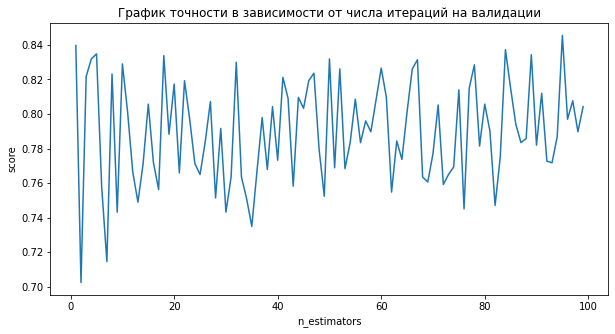

In [153]:
fig = plt.figure(figsize=(10,5))
plt.xlabel('n_estimators')
plt.ylabel('score')
plt.title('График точности в зависимости от числа итераций на валидации')
plt.plot(range(1, 100), accuracy)
plt.show()

In [154]:
print(max(accuracy))

0.8454457364341085


In [155]:
my_param['n_estimators'] = range(1,100)[np.argmax(accuracy)]
print(my_param)

{'n_estimators': 95}


In [156]:
model_score = {}
for n in tqdm.tqdm(['mse', 'exp', 'log']):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, 
                                                        stratify=y)
    my_param['loss'] = n
    my_clf = MyGradientBoostingClassifier(**my_param)
    my_clf.fit(X_train, y_train)
    model_score[n] = accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test) 






  0%|          | 0/3 [00:00<?, ?it/s]




 33%|███▎      | 1/3 [00:34<01:08, 34.11s/it]




 67%|██████▋   | 2/3 [00:38<00:25, 25.23s/it]




100%|██████████| 3/3 [00:43<00:00, 14.37s/it]


In [157]:
my_param['loss'] = list(model_score.keys())[np.argmax(model_score.values())]
print(my_param)

{'n_estimators': 95, 'loss': 'mse'}


In [159]:
LR_score = []
for n in tqdm.tqdm([0.01, 0.03, 0.05, 0.07, 0.1, 0.3, 0.5, 0.7, 0.8, 0.9]):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, 
        stratify=y)
    my_param['learning_rate'] = n
    my_clf = MyGradientBoostingClassifier(**my_param)
    my_clf.fit(X_train, y_train)
    LR_score.append(accuracy_score(y_pred=my_clf.predict(X_test), 
        y_true=y_test)) 







  0%|          | 0/10 [00:00<?, ?it/s]





 10%|█         | 1/10 [00:46<06:56, 46.29s/it]





 20%|██        | 2/10 [01:37<06:21, 47.74s/it]





 30%|███       | 3/10 [02:33<05:52, 50.35s/it]





 40%|████      | 4/10 [03:34<05:20, 53.49s/it]





 50%|█████     | 5/10 [04:28<04:27, 53.56s/it]





 60%|██████    | 6/10 [05:01<03:10, 47.54s/it]





 70%|███████   | 7/10 [05:13<01:50, 36.76s/it]





 80%|████████  | 8/10 [06:28<01:36, 48.20s/it]





 90%|█████████ | 9/10 [07:41<00:55, 55.72s/it]





100%|██████████| 10/10 [08:52<00:00, 53.26s/it]


In [160]:
my_param['learning_rate'] = [0.01, 0.03, 0.05, 0.07, 0.1, 0.3, 
                             0.5, 0.7, 0.8, 0.9][np.argmax(LR_score)]

In [161]:
colsample_score = []
for n in tqdm.tqdm(np.arange(0.1, 1.1, 0.1)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, 
        stratify=y)
    my_param['colsample'] = n
    my_clf = MyGradientBoostingClassifier(**my_param)
    my_clf.fit(X_train, y_train)
    colsample_score.append(accuracy_score(y_pred=my_clf.predict(X_test), 
        y_true=y_test)) 







  0%|          | 0/10 [00:00<?, ?it/s]





 10%|█         | 1/10 [00:23<03:34, 23.87s/it]





 20%|██        | 2/10 [00:55<03:28, 26.10s/it]





 30%|███       | 3/10 [01:27<03:15, 27.96s/it]





 40%|████      | 4/10 [02:02<03:01, 30.23s/it]





 50%|█████     | 5/10 [02:42<02:44, 32.89s/it]





 60%|██████    | 6/10 [03:23<02:21, 35.46s/it]





 70%|███████   | 7/10 [04:08<01:55, 38.39s/it]





 80%|████████  | 8/10 [04:52<01:20, 40.06s/it]





 90%|█████████ | 9/10 [05:40<00:42, 42.51s/it]





100%|██████████| 10/10 [06:34<00:00, 39.45s/it]


In [162]:
my_param['colsample'] = np.arange(0.1, 1.1, 0.1)[np.argmax(colsample_score)]

In [163]:
subsample_score = []
for n in tqdm.tqdm(np.arange(0.1, 1.1, 0.1)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, 
        stratify=y)
    my_param['subsample'] = n
    my_clf = MyGradientBoostingClassifier(**my_param)
    my_clf.fit(X_train, y_train)
    subsample_score.append(accuracy_score(y_pred=my_clf.predict(X_test), 
        y_true=y_test)) 







  0%|          | 0/10 [00:00<?, ?it/s]





 10%|█         | 1/10 [00:04<00:38,  4.31s/it]





 20%|██        | 2/10 [00:12<00:44,  5.60s/it]





 30%|███       | 3/10 [00:26<00:56,  8.13s/it]





 40%|████      | 4/10 [00:45<01:07, 11.18s/it]





 50%|█████     | 5/10 [01:08<01:14, 14.82s/it]





 60%|██████    | 6/10 [01:36<01:15, 18.88s/it]





 70%|███████   | 7/10 [02:10<01:09, 23.19s/it]





 80%|████████  | 8/10 [02:48<00:55, 27.70s/it]





 90%|█████████ | 9/10 [03:32<00:32, 32.58s/it]





100%|██████████| 10/10 [04:20<00:00, 26.09s/it]


In [164]:
my_param['subsample'] = np.arange(0.1, 1.1, 0.1)[np.argmax(subsample_score)]

In [209]:
my_clf = MyGradientBoostingClassifier(**my_param)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
my_clf.fit(X_train, y_train)
print(my_param)
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

{'n_estimators': 95, 'loss': 'mse', 'learning_rate': 0.03, 'colsample': 0.9, 'subsample': 0.6}
0.8890503875968992


## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [226]:
from sklearn.ensemble import RandomForestRegressor

In [227]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [228]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

(20640, 8) (20640,)


In [219]:
my_clf = MyGradientBoostingClassifier(**my_param)
my_clf.fit(X_train, y_train, init_model=RandomForestRegressor)
print("BooBag: ",accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

BooBag:  0.9031007751937985


Качество улучшилось. Скорее всего, дисперсия была довольно большой в бустинге из-за переобучения, и усреднение на каждом шаге по деревьям дисперсию уменьшило уменьшило. (Дисперсия это variance)

In [235]:
my_mod_clf = []
for i in tqdm.tqdm(range(20)):
    idx = np.random.randint(0, len(X_train), len(X_train))
    cur_X = X_train[idx]
    
    cur_y = y_train[idx]
    my_clf = MyGradientBoostingClassifier(**my_param)
    my_clf.fit(cur_X, cur_y)
    my_mod_clf.append(my_clf)







  0%|          | 0/20 [00:00<?, ?it/s]





  5%|▌         | 1/20 [00:30<09:32, 30.15s/it]





 10%|█         | 2/20 [00:59<08:59, 29.96s/it]





 15%|█▌        | 3/20 [01:30<08:35, 30.35s/it]





 20%|██        | 4/20 [01:59<07:58, 29.93s/it]





 25%|██▌       | 5/20 [02:29<07:25, 29.72s/it]





 30%|███       | 6/20 [02:58<06:53, 29.53s/it]





 35%|███▌      | 7/20 [03:27<06:21, 29.38s/it]





 40%|████      | 8/20 [03:57<05:54, 29.54s/it]





 45%|████▌     | 9/20 [04:27<05:27, 29.82s/it]





 50%|█████     | 10/20 [04:57<04:58, 29.81s/it]





 55%|█████▌    | 11/20 [05:27<04:29, 29.93s/it]





 60%|██████    | 12/20 [05:58<04:01, 30.18s/it]





 65%|██████▌   | 13/20 [06:27<03:28, 29.83s/it]





 70%|███████   | 14/20 [06:56<02:58, 29.72s/it]





 75%|███████▌  | 15/20 [07:26<02:27, 29.59s/it]





 80%|████████  | 16/20 [07:56<01:59, 29.81s/it]





 85%|████████▌ | 17/20 [08:26<01:29, 29.75s/it]





 90%|█████████ | 18/20 [08:55<00:59, 29.79s/it]





 95%|

In [236]:
predict= [model.predict(X_test) for model in my_mod_clf]
y_pred = (np.mean(predict, axis = 0) > 0.5).astype('int')
print("BagBoo: ", accuracy_score(y_test, y_pred))

BagBoo:  0.8948643410852714


Качество стало лучше. Тут мы получили несколько моделей бустинга с маленьким смещением и не маленькой дисперсией, но за счет бустинга мы уменьшаем эту дисперсию.

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [237]:
def smart(init_model=None):
    my_clf = MyGradientBoostingClassifier(**my_param)
    my_clf.fit(X_train, y_train, init_model=init_model)
    return accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

In [245]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

models = [LinearRegression, RandomForestRegressor, KNeighborsRegressor, 
          Lasso]

for cur_mod in tqdm.tqdm(models):
    print('\n{0}: accuracy = {1}\n'.format(cur_mod.__name__, smart(init_model=cur_mod)))









  0%|          | 0/4 [00:00<?, ?it/s]







 25%|██▌       | 1/4 [00:36<01:50, 36.70s/it]


LinearRegression: accuracy = 0.8977713178294574











 50%|█████     | 2/4 [01:33<01:25, 42.79s/it]


RandomForestRegressor: accuracy = 0.8914728682170543











 75%|███████▌  | 3/4 [02:20<00:43, 43.91s/it]


KNeighborsRegressor: accuracy = 0.8846899224806202











100%|██████████| 4/4 [02:55<00:00, 43.94s/it]


Lasso: accuracy = 0.8938953488372093



Качество стало чуть лучше в случае инициализации линейной моделью. Всё из-за того, что уже на первом шаге мы получили более точное решение, ошибки которого нам проще исправить.

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

